Fork of Phil Notebook. I'll start by quickly recap-ing what that one accomplished, and what might be done better here!

In that last notebook, we used a pretty direct implementation of the REINFORCE algorithm to tackle the LunarLander environment. Main differences were that this version of the algorithm depended on rewards to go already, which was a key point noted during the lecture, but such a huge + easy improvement it's not worth seeing how the agent performs under the far less stable regime of all rewards included.  Additionally, discounting was already implemented. This too is a pretty important variance reduction technique, and if I wanted to explore what it looks like without discounting, it's far easier to do so by just setting $\gamma = 1$ rather than removing it entirely.  

The next step I want to implement is to get a better estimate of the expected reward to go, rather than the reward to go by episode. 

There are kind of two ways to implement this, and I will briefly touch on them now. 

One is the batch policy gradient. In this case, we are still using the single episode reward-to-go estimate, but are computing the policy gradient loss over a batch of episodes simultaneously, and stepping in that direction. While that doesn't exactly mean we are computing the expected reward to go, taking an expectation over different trajectories should mean we are getting closer to this estimate of a stochastic reward to go by including a batch of options at once. 


This batch policy is mathematically expressed as $$\nabla_{\theta} J(\theta) = \frac{1}{N} \sum_{i=1}^N \sum_{t=1}^T \nabla_{\theta} log \pi_{\theta}(a_{i,t} | s_{i,t}) (\sum_{t'=t}^T r(s_{i,t'}, a_{i,t'}))$$

Where the vanilla version used previously assumed $N=1$. Including in more trajectories at once allows us to have a more accurate estimate of the true gradient, leading us towards the optimal policy which I might as well add in here is equal to 

$$\theta^* = argmax_{\theta} E_{\tau \approx \pi_{\theta}(\tau)} [r(\tau)]$$ where $\tau$ represents the joint distribution over time steps in the episode, i.e summing from $t=1$ to $T$.

The derivation from this optimization problem to the policy gradient involves taking the derivative of $J(\theta)$, the joint distribution expressed as a product of conditional probabilities, and then applying some neat tricks. 



Coming back from that tangent, the other point I wanted to make was that an even better estimation of the policy gradient could include the expected reward to go, which would be equivalent to the following: 


$$\nabla_{\theta} J(\theta) = \frac{1}{N} \sum_{i=1}^N \sum_{t=1}^T \nabla_{\theta} log \pi_{\theta}(a_{i,t} | s_{i,t}) E_{\pi_{\theta}}[r(s_{i,t},a_{i,t} )| s_{i,t}, a_{i,t}]$$.

This latter term is also the same as the $Q$ function, and am going to leave it for a future notebook. 

And last but not least, there is also the addition of a baseline, $b$, which can be added in to reduce the variance of a policy gradient estimation. This baseline (especially ones that are a function of the state you are in) will be properly mentioned in the notebook for actor critics, so for now I'll work with a constant one, which subtracts by the average reward per episode. This serves as a relative reward adjustment, and make things a little easier for the agent to decipher. Turns out this was already done in the original notebook, at least on a per episode basis, but now I'll do it on a per-batch basis. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym 
#from gym import wrappers
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class PolicyNetwork(nn.Module):
    def __init__(self,lr,input_dims,fc1_dims,fc2_dims,n_actions):
        super(PolicyNetwork,self).__init__()
        self.input_dims = input_dims
        self.lr = lr
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims,self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims,self.n_actions)
        
        self.optimizer = torch.optim.Adam(self.parameters(),lr=lr)
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        self.to(self.device)
        
    def forward(self,observation):
        state = torch.Tensor(observation).to(self.device)
        
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) #no activation, handled later
        
        return x

    
#Now the agent class. We express things in terms of classes and objects, a fundamental building block of 
# OOP and comp sci. 

class Agent(object):
    #contains policy network and more!
    def __init__(self, lr, input_dims, gamma = 0.99, n_actions = 4, l1_size = 256, l2_size = 256,batch_size = 32):
    
        self.gamma = gamma
        self.reward_memory = [] #way of keeping track of rewards 
        self.action_memory = [] # and actions the agent took
        self.batch_action_memory = [] #way to keep track or rewards and action lists inside a list of length batch size
        self.batch_reward_memory = []
        self.batch_size = batch_size
        self.policy = PolicyNetwork(lr, input_dims, l1_size, l2_size, n_actions) #probability distribution used by the agent to select actions, given an observation/state. 
    
    def choose_action(self, observation):
        probabilities = F.softmax(self.policy.forward(observation))
        
        #now calculate an actual distribution from this. 
        
        action_probs = torch.distributions.Categorical(probabilities) # probability distribuition dictated by policy network
        
        # now we pick an action using sample method.
        
        action = action_probs.sample()
        
        #keep track of action log probability... log pi!  You know this!
        
        log_probs = action_probs.log_prob(action) #clearly this is a Pytorch specific method of how to select. 
        #looks like it takes distribution, and calculates log probability of that specific action. cool. 
        
        
        #now save. 
        
        self.action_memory.append(log_probs) #save a step in an episode. 
        
        #return an action
        
        return action.item() #this item is an integer, now able to get fed into gym env. 
    
    def store_rewards(self,reward):
        self.reward_memory.append(reward) #why not just do this in main? idk, it's a little more convenient. 
        
        
    def learn(self):
        #heart of the problem. Now for doing it with an entire batch..
        
        
        self.policy.optimizer.zero_grad()
        
        
        
        #It learns at the end of the episode, which is not a good thing! Would want an average of future returns, not per ep. 
        Gs = []
        for episode in self.batch_reward_memory:
            
            G = np.zeros_like(self.reward_memory,dtype = np.float64) #For mc Reinforce
            for t in range(len(self.reward_memory)):
                G_sum = 0
                discount = 1 
                for k in range(t,len(self.reward_memory)): #why from t? Rewards to go! 
                    G_sum += self.reward_memory[k] * discount
                    discount *= self.gamma  # decreases for future time steps. 
                
                G[t] = G_sum  # at the end of episode, store sum of returns at timestep t
            
            #standardize to reduce variance. Free lunch! 
            mean = np.mean(G)
            std = np.std(G) if np.std(G) > 0 else 1

            G = (G - mean)/std
            G = torch.Tensor(G).to(self.policy.device) #for some reason, worked like this. Phil had to use a specific data type. 
            Gs.append(G)
        
        
        loss = 0
        for G, action_memory in zip(Gs, self.batch_action_memory):
            for g, logprob in zip(G, action_memory):
                loss += -g * logprob #weight each probbility by future + current reward at that timestpe

                    #it's objective is to maximize this prbabil8ty 
            #spoilers. To do this for multiple trajectories, need to iterate over N episodes, and average these losses. 
            
            #another spoiler. Baseline should be subjtracted from here, perhaps just as mean G? 
            
            # another spoiler. Critic also goes here too! 
        #backprop!
        loss = loss / self.batch_size # so it's an average. 
        
        loss.backward()
        self.policy.optimizer.step()

        #zero out and repeat. This is a Sample inefficient MC, and a future improvement 
        self.action_memory = []
        self.reward_memory = []
        self.batch_action_memory = []
        self.batch_reward_memory = []

            #now for the main!
            

In [4]:
#Main 
score_history = []
score = 0
n_episodes = 800
batch_size = 1
env = gym.make('LunarLander-v2')
#env = gym.make('MountainCar-v0')

agent = Agent(lr = 0.001, input_dims=[8],gamma=0.99,n_actions=4
             ,l1_size=128,l2_size=128,batch_size=batch_size)



#env = wrappers.Monitor(env, 'tmp/lunar-lander',
 #                      video_callable=lambda episodeid: True, force=True)

for i in range(n_episodes):

    for _ in range(batch_size):
        done = False
        score = 0
        observation = env.reset()
        while not done:
           # env.render()
            action = agent.choose_action(observation)
            observation_,reward, done, info = env.step(action)
            agent.store_rewards(reward)
            observation = observation_ #set the old obvs to the new one
            score += reward
        agent.batch_action_memory.append(agent.action_memory)
        agent.batch_reward_memory.append(agent.reward_memory)
    
    score_history.append(score)
    agent.learn()
    #print('episode : ', i, 'score ', score)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/Users/noahkasmanoff/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: 

Should be better, we will plot same plot as prior in a moment and compare ... 

Text(0, 0.5, 'Total Rewards')

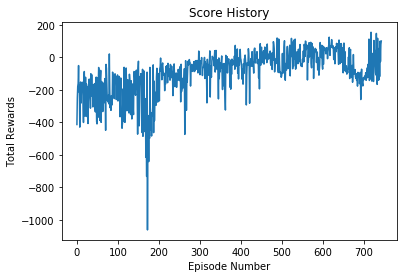

In [5]:
plt.title("Score History")
plt.plot(score_history)
plt.xlabel("Episode Number")
plt.ylabel("Total Rewards")

In [5]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [11]:
def plot_reward_history(reward_history,N=15,agent='PG'):
    import seaborn as sns
    sns.set_style('darkgrid')
    sns.set_palette('husl')
    plt.figure()
    plt.plot(reward_history,label = agent)
    
    running_history = running_mean(reward_history,N=N)
    plt.plot(running_history,label = agent + ' '+ str(N) + ' episode running mean')
    
    plt.title("Reward History",fontsize = 15)
    plt.xlabel("Episodes",fontsize = 15)
    plt.ylabel("Total Reward", fontsize = 15)
    plt.legend()

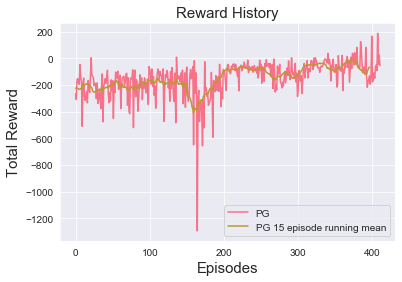

In [12]:
plot_reward_history(reward_history=score_history)

Conclusion from this section. Suprisingly, batch policy gradient, at least in this one environment/situation, takes longer to converge than the ordinary sample estimate. Why might that be? A few obvious reasons come to mind. To start, less gradient updates. Additionally, these episodes diverge relatively quickly, so these are all pretty different trajectories averaged together, and as we learned early on in this couse, that could lead to a policy that is not compatible with any of the distinct trajectories undergone. 

Quick addition: Make a plot for reward history which can be applied wherever:

Wish list on it includes

- running average

- std deviation upper and lower bounds of rewards

- Name of agent type (i.e policy gradient, AC)

- title is environment 



SyntaxError: invalid syntax (<ipython-input-8-9b9566cb8696>, line 1)